## 前置作業

### 引入套件

gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。

而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [1]:
# 匯入 matplotlib 庫，用於繪圖
import matplotlib.pyplot as plt

# 從 IPython 匯入 display，用於在 Jupyter notebook 中顯示圖形
from IPython import display

# 匯入 numpy 庫，用於數值計算
import numpy as np

# 匯入 PyTorch，該庫用於深度學習
import torch

# 從 torch.nn 中匯入神經網路模組
import torch.nn as nn

# 匯入優化器模組，用於優化神經網路參數
import torch.optim as optim

# 匯入函數式模組，包含許多常用的深度學習函數
import torch.nn.functional as F

# 從 torch.distributions 中匯入 Categorical，這是用於處理離散機率分佈的模組
from torch.distributions import Categorical

# 匯入 tqdm.notebook，用於在 Jupyter notebook 中顯示進度條
from tqdm.notebook import tqdm


### Random Seed

In [2]:
seed = 543 # Do not change this
def fix(env, seed):
  # env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.torch.use_deterministic_algorithms(True)
  torch.are_deterministic_algorithms_enabled()
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

## 建立 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) Game

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。

> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

所謂的「環境」其實同時包括了 agent 和 environment。

我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 state 和 reward。

In [3]:
import gym
import random
import numpy as np

env = gym.make('LunarLander-v2', render_mode="rgb_array")

fix(env, seed)

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [4]:
type(env.observation_space), env.observation_space.shape 


(gym.spaces.box.Box, (8,))

`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [5]:
env.action_space

Discrete(4)

`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

### Step: agent 和 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [6]:
initial_state = env.reset()
print("state:", initial_state[0])
print("其餘資訊:", initial_state[1])

state: [ 0.00736828  1.4108332   0.74630535 -0.00388728 -0.00853116 -0.16904932
  0.          0.        ]
其餘資訊: {}


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [7]:
random_action = env.action_space.sample()
print(random_action)

3


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [8]:
observation, reward, done, truncate, info = env.step(random_action)

### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分

In [9]:
print(reward) # after doing a random action (0), the immediate reward is stored in this 

-2.0899525086657307


### Random Agent

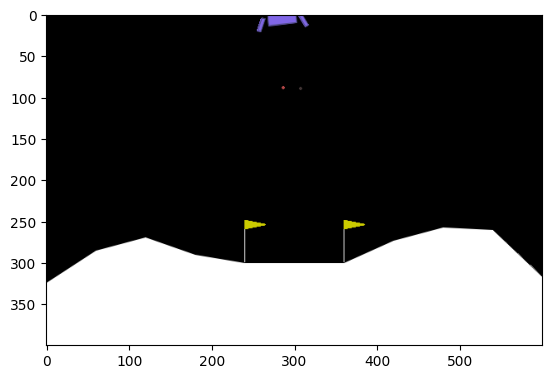

In [10]:
env.reset()
img = plt.imshow(env.render())

done = False
cnt = 0
while not done:
    action = env.action_space.sample()
    observation, reward, done, truncate, _ = env.step(action)
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if cnt < 10:
        cnt += 1
    else:
        break

## Policy Gradient

搭建簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [23]:
class PolicyGradientNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [24]:
class PolicyGradientAgent():
    
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
         
    def forward(self, state):
        return self.network(state)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def save(self, PATH): 
        Agent_Dict = {
            "network" : self.network.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(Agent_Dict, PATH)

    def load(self, PATH): 
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["network"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])


In [22]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [17]:
state = env.reset()
state

(array([ 0.00229616,  1.4003068 ,  0.23256728, -0.47170618, -0.00265395,
        -0.05267997,  0.        ,  0.        ], dtype=float32),
 {})

In [20]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 400        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state, _ = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at , log(at|st)
            next_state, reward, done, _, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward) #改這裡
            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

    print(f"rewards looks like ", np.shape(rewards))  
    # print(f"log_probs looks like ", np.shape(log_probs))     
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

  0%|          | 0/400 [00:00<?, ?it/s]

rewards looks like  (513,)
logs prob looks like  torch.Size([513])
torch.from_numpy(rewards) looks like  torch.Size([513])
rewards looks like  (518,)
logs prob looks like  torch.Size([518])
torch.from_numpy(rewards) looks like  torch.Size([518])
rewards looks like  (486,)
logs prob looks like  torch.Size([486])
torch.from_numpy(rewards) looks like  torch.Size([486])
rewards looks like  (510,)
logs prob looks like  torch.Size([510])
torch.from_numpy(rewards) looks like  torch.Size([510])
rewards looks like  (521,)
logs prob looks like  torch.Size([521])
torch.from_numpy(rewards) looks like  torch.Size([521])
rewards looks like  (433,)
logs prob looks like  torch.Size([433])
torch.from_numpy(rewards) looks like  torch.Size([433])
rewards looks like  (460,)
logs prob looks like  torch.Size([460])
torch.from_numpy(rewards) looks like  torch.Size([460])


KeyboardInterrupt: 